In [1]:
from typing import Tuple
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Define functions

The function for training `QDA` :
- takes the inputs : $X_{app}$ (training input matrix $n, p$), $z_{app}$ (binary class indicator matrix $n, K$), $m_{prior}$ (Gaussian prior expectation matrix $K, p$), $df_{exp}$ (Gaussian prior shrinkage parameter), $S_{prior}$ (covariance matrix $p, p, K$ for the inverse -Wishart prior), $df_{cov}$ (degree of freedom of the inverse-Wishart prior)
- provides : $pi$ (vector $K, 1$ of class proportions), $mu$ (estimated expectation matrix $K, p$), $Sig$ (estimated covariance matrices $p, p, K$)

In [2]:
def data_processing(file_url : str,
                    n_components_pca : int = None,
                    test_size : float = 0.3) -> Tuple:
    """
    :param file_url: Path to dataset file
    :param n_components_pca : Number of principal components we extract from the dataset
    :param test_size : Number from 0 to 1, the portion of test set
    """
    # read data from cvs file and convert it into numpy array
    data = pd.read_csv(file_url, header=0)
    data = data.to_numpy()
    
    # apply PCA if necessary
    if n_components_pca is not None:
        data_y = data[:, -1]
        data_X = data[:, :-1]
        pca = PCA(n_components=n_components_pca)
        data_X = pca.fit_transform(data_X)
        data = np.hstack((data_X, data_y.reshape((-1,1))))
    
    # transform outputs (labels) into indices to easier manipulate
    classes = sorted(collections.Counter(list(data[:, -1])).keys())
    classes_with_index = {}
    K = len(classes)
    n, p = data.shape[0], data.shape[1] - 1
    for i_class in range(K):
        classes_with_index[i_class] = classes[i_class]
        data[data[:, -1] == classes[i_class], -1] = i_class
    print("Ours classes are enumerated as bellow : \n", classes_with_index)
    
    # split data to training set and test set
    if test_size > 1 or test_size < 0:
        raise IndexError("invalid value of test_size")
    else:
        Xapp, Xtst, yapp, ytst = train_test_split(data[:, :-1], data[:, -1],
                                                  test_size=test_size)
        Zapp = np.zeros((len(yapp), K))
        Ztst = np.zeros((len(ytst), K))
        for i in range(len(yapp)):
            Zapp[i, int(yapp[i])] = 1
        for i in range(len(ytst)):
            Ztst[i, int(ytst[i])] = 1
    
    # compute mprior (expected value) and Sprior (covariance's matrices)
    mprior = np.zeros((K, p))
    Sprior = np.zeros((p, p, K))
    for j in range(K):
        temp = data[data[:, -1] == j, :-1]
        temp = temp.astype(float)
        mprior[j, :] = temp.mean(axis = 0)
        Sprior[:, :, j] = np.cov(temp, rowvar=False)
    return Xapp, Zapp, Xtst, Ztst, mprior, Sprior

We define a `data_processing` function to test different dataset. The function does respectively :
- Read the dataset by the `pandas` library and transform it to the one in form of the `numpy` library in order to facilitate our next works.
- Apply PCA filtering process to the dataset if necessary.
- Sort all classes of the dataset and display their enumeration
- Separate the dataset into training and test ones by `cut_off` coefficient predefined at `0.9`
- Calculate the prior expectation and variance based on the training set

In [3]:
def QDA(Xapp : np.array,
        zapp  : np.array,
        mprior : np.array,
        df_exp : float,
        Sprior : np.array,
        df_cov : float) -> Tuple:
    """
    :param Xapp: feature of training set
    :param zapp : label of training set
    :param mprior : emperical prior of expected value
    :param df_exp : shrinkage parameter
    :param Sprior : emperical prior of covariance matrices
    :param df_cov : degrees of freedom of the inverse-Wishart prior
    """
    
    # n : number of samples, p : number of feature, K : number of classes
    n, p, K =  Xapp.shape[0], Xapp.shape[1], zapp.shape[1]
    
    # compute estimators of pi, mu, Sig
    pi = np.zeros(K)
    mu = np.zeros((K, p))
    B = np.zeros((p, p, n))
    Sig = np.zeros((p, p, K))
    
    pi = np.mean(zapp, axis=0)
    for j in range(K):
        mu[j, :] = (sum(zapp[i, j] * Xapp[i, :] for i in range(n)) 
                    + df_exp * mprior[j, :]) / (sum(zapp[:, j]) + df_exp)
        
        for i in range(n):
            temp = (Xapp[i, :] - mprior[j, :]).reshape((p, -1))
            B[:, :, i] = temp @ temp.T
        
        Sig[:, :, j] = (sum((zapp[i, j] * B[:, :, i]) for i in range(n)) + 
                        df_exp * (mu[j, :] - mprior[j, :]) @ (mu[j, :] - 
                                                              mprior[j, :]).T + 
                        Sprior[:, :, j].T) / (sum(zapp[:, j]) + df_cov + p + 2)
    return pi, mu, Sig

In [4]:
def QDA_without_prior(Xapp : np.array,
                      zapp  : np.array) -> Tuple:
    """
    :param Xapp: feature of training set
    :param zapp : label of training set
    """
    # n : number of samples, p : number of feature, K : number of classes
    n, p, K =  Xapp.shape[0], Xapp.shape[1], zapp.shape[1]
    
    # compute estimators of pi, mu, Sig
    pi = np.zeros(K)
    mu = np.zeros((K, p))
    B = np.zeros((p, p, n))
    Sig = np.zeros((p, p, K))
    
    pi = np.mean(zapp, axis=0)
    for j in range(K):
        mu[j, :] = sum(zapp[i, j] * Xapp[i, :] for i in range(n))
        
        for i in range(n):
            temp = (Xapp[i, :] - mu[j, :]).reshape((p, -1))
            
            B[:, :, i] = temp @ temp.T
        
        Sig[:, :, j] = sum((zapp[i, j] *
                            B[:, :, i]) for i in range(n)) / sum(zapp[:, j])
    return pi, mu, Sig

The function for evaluating test set `evaluation` :
- takes the inputs : $X_{tst}$ (test input matrix $n, p$), $pi$ (vector $K, 1$ of class proportions), $mu$ (estimated expectation matrix $K, p$), $Sig$ (estimated covariance matrices $p, p, K$)
- provides : $prob$ (matrix $n, K$ of estimated class posterior probabilities) and $pred$ (vector $n, 1$ of corresponding decisions)

In [5]:
def evaluation(Xtst : np.array,
               pi : np.array,
               mu : np.array,
               Sig : np.array) -> Tuple:
    """
    :param Xtst: feature of test set
    :param pi : estimator of  class proportions
    :param mu : estimator of  expectations
    :param Sig : estimator of  covariance matrices
    """
    # n : number of samples, p : number of feature, K : number of classes
    n, p, K = Xtst.shape[0], Xtst.shape[1], len(pi)
    
    prob = np.zeros((n, K))
    pred = np.zeros(n)
    
    # function which compute density
    f = lambda x, mu, Sig: (2*np.pi)**(-len(x)/2) * np.linalg.det(Sig)**(-1/2) * np.exp((-1/2) *(x - mu).T
                                                                                        @ np.linalg.inv(Sig)
                                                                                        @ (x - mu))
   
    # compute probabilitie's vector for K classes
    for j in range(K):
        for i in range(n):
            total = sum(pi[k] * f(Xtst[i, :], mu[k, :],
                                  Sig[:, :, k]) for k in range(K))
            prob[i, j] = pi[j] * f(Xtst[i, :], mu[j, :], Sig[:, :, j]) / total
        
    pred = np.argmax(prob, axis=1)
    
    return prob, pred

## Optdigits test

In [6]:
Xapp_opt, Zapp_opt, Xtst_opt, Ztst_opt, mprior_opt, Sprior_opt = data_processing(
                                            "dataset/optdigits.csv", n_components_pca=10)

df_exp_opt = 0.1
df_cov_opt = Xapp_opt.shape[1] + 1

pi_opt, mu_opt, Sig_opt = QDA(Xapp_opt, Zapp_opt, mprior_opt, df_exp_opt, Sprior_opt, df_cov_opt)
prob_opt, pred_opt = evaluation(Xtst_opt, pi_opt, mu_opt, Sig_opt)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_opt, axis=1), pred_opt))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_opt, axis=1), pred_opt))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_opt, axis=1), pred_opt, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
-----------------------------------------------------------


Confusion matrix

 [[178   0   0   0   3   0   0   0   0   0]
 [  0 156   0   0   1   0   0   0   1   1]
 [  0   1 168   0   0   0   0   0   1   0]
 [  0   0   0 156   0   1   0   1   1   1]
 [  0   0   0   0 163   0   0   2   0   1]
 [  0   0   0   1   0 164   0   0   1   6]
 [  0   1   0   0   0   0 171   0   0   0]
 [  0   2   0   0   1   0   0 174   0   0]
 [  0   8   0   2   0   0   0   1 149   2]
 [  0   1   0   2   0   1   0   7   2 154]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.98      0.99       181
           1       0.92      0.98      0.95       159
           2       1.00      0.99      0.99       170
           3       0.97      0.97      0.97       160
        

In [7]:
pi_opt_2, mu_opt_2, Sig_opt_2 = QDA_without_prior(Xapp_opt, Zapp_opt)
prob_opt_2, pred_opt_2 = evaluation(Xtst_opt, pi_opt_2, mu_opt_2, Sig_opt_2)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_opt, axis=1), pred_opt_2))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_opt, axis=1), pred_opt_2))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_opt, axis=1), pred_opt_2, average='weighted'))

-----------------------------------------------------------


Confusion matrix

 [[176   0   0   0   4   0   0   0   0   1]
 [  0 151   0   1   1   2   0   0   3   1]
 [  0   3 164   0   0   3   0   0   0   0]
 [  0   0   1 153   1   1   1   2   1   0]
 [  0   0   2   0 162   0   0   2   0   0]
 [  0   0   0   2   0 157   0   0   4   9]
 [  0   0   0   1   0   0 167   1   1   2]
 [  0   3   1   1   1   1   0 168   2   0]
 [  0  10   1   7   2   0   0   0 138   4]
 [  0   1   0   2   1   2   3   7   4 147]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.97      0.99       181
           1       0.90      0.95      0.92       159
           2       0.97      0.96      0.97       170
           3       0.92      0.96      0.94       160
           4       0.94      0.98      0.96       166
           5       0.95      0.91      0.93       172
           6       0.98

Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}


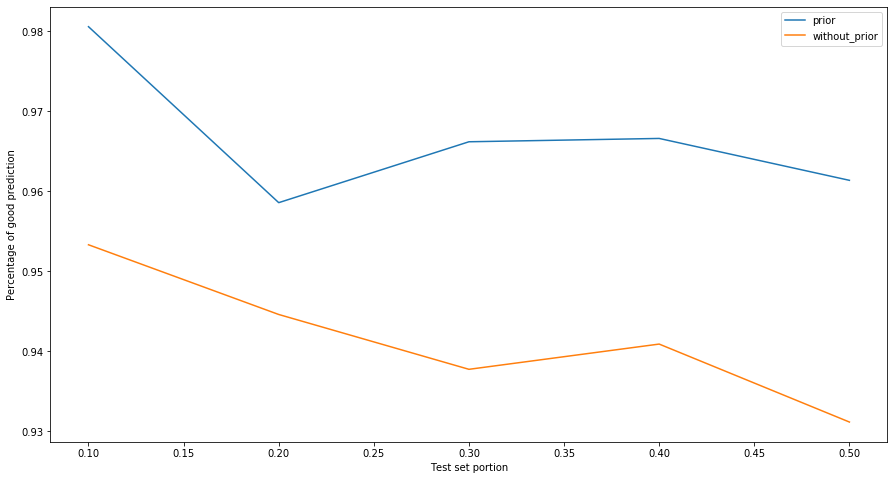

In [8]:
test_size = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(test_size))
prediction_without_prior = np.zeros(len(test_size))

for i in range(len(test_size)):
    Xapp_opt, Zapp_opt, Xtst_opt, Ztst_opt, mprior_opt, Sprior_opt = data_processing(
                                            "dataset/optdigits.csv", n_components_pca=10, test_size=test_size[i])
    
    pi_opt, mu_opt, Sig_opt = QDA(Xapp_opt, Zapp_opt, mprior_opt, df_exp_opt, Sprior_opt, df_cov_opt)
    prob_opt, pred_opt = evaluation(Xtst_opt, pi_opt, mu_opt, Sig_opt)
    prediction[i] = precision_score(np.argmax(Ztst_opt, axis=1), pred_opt, average='weighted')
    
    pi_opt_2, mu_opt_2, Sig_opt_2 = QDA_without_prior(Xapp_opt, Zapp_opt)
    prob_opt_2, pred_opt_2 = evaluation(Xtst_opt, pi_opt_2, mu_opt_2, Sig_opt_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_opt, axis=1), pred_opt_2, average='weighted')

plt.figure(figsize=(15, 8))
plt.plot(test_size, prediction)
plt.plot(test_size, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

## Page Blocks test

In [9]:
Xapp_pag, Zapp_pag, Xtst_pag, Ztst_pag, mprior_pag, Sprior_pag = data_processing("dataset/page-blocks.csv",
                                                                                    n_components_pca=8)

df_exp_pag = 0.1
df_cov_pag = Xapp_pag.shape[1] + 20

pi_pag, mu_pag, Sig_pag = QDA(Xapp_pag, Zapp_pag, mprior_pag, df_exp_pag, Sprior_pag, df_cov_pag)
prob_pag, pred_pag = evaluation(Xtst_pag, pi_pag, mu_pag, Sig_pag)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_pag, axis=1), pred_pag))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_pag, axis=1), pred_pag))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_pag, axis=1), pred_pag, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
-----------------------------------------------------------


Confusion matrix

 [[1337   19    2   77   24]
 [  18   76    0   12    1]
 [   0    0    7    0    4]
 [   0    0    0   30    1]
 [   8    0    2    6   18]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.98      0.92      0.95      1459
           1       0.80      0.71      0.75       107
           2       0.64      0.64      0.64        11
           3       0.24      0.97      0.38        31
           4       0.38      0.53      0.44        34

    accuracy                           0.89      1642
   macro avg       0.61      0.75      0.63      1642
weighted avg       0.94      0.89      0.91      1642

-----------------------------------------------------------


Precision score

 0.9402915623718189


In [10]:
pi_pag_2, mu_pag_2, Sig_pag_2 = QDA_without_prior(Xapp_pag, Zapp_pag)
prob_pag_2, pred_pag_2 = evaluation(Xtst_pag, pi_pag_2, mu_pag_2, Sig_pag_2)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_pag, axis=1), pred_pag_2))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_pag, axis=1), pred_pag_2))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_pag, axis=1), pred_pag_2, average='weighted'))

-----------------------------------------------------------


Confusion matrix

 [[1078   18    3  323   37]
 [  28   63    0   14    2]
 [   0    0    7    0    4]
 [   0    0    0   31    0]
 [   5    0    3    8   18]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.97      0.74      0.84      1459
           1       0.78      0.59      0.67       107
           2       0.54      0.64      0.58        11
           3       0.08      1.00      0.15        31
           4       0.30      0.53      0.38        34

    accuracy                           0.73      1642
   macro avg       0.53      0.70      0.52      1642
weighted avg       0.92      0.73      0.80      1642

-----------------------------------------------------------


Precision score

 0.9241152883258272


Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}


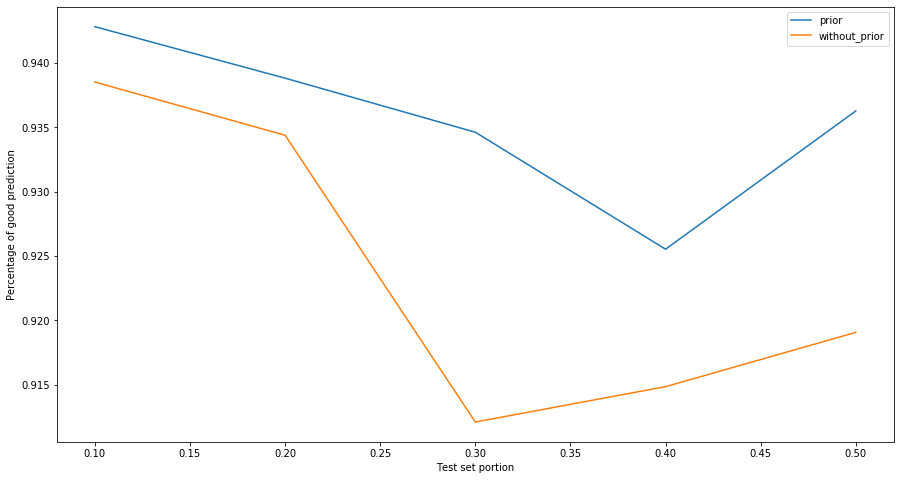

In [11]:
test_size = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(test_size))
prediction_without_prior = np.zeros(len(test_size))

for i in range(len(test_size)):
    Xapp_pag, Zapp_pag, Xtst_pag, Ztst_pag, mprior_pag, Sprior_pag = data_processing("dataset/page-blocks.csv",
                                                                                    n_components_pca=8)

    pi_pag, mu_pag, Sig_pag = QDA(Xapp_pag, Zapp_pag, mprior_pag, df_exp_pag, Sprior_pag, df_cov_pag)
    prob_pag, pred_pag = evaluation(Xtst_pag, pi_pag, mu_pag, Sig_pag)
    prediction[i] = precision_score(np.argmax(Ztst_pag, axis=1), pred_pag, average='weighted')

    pi_pag_2, mu_pag_2, Sig_pag_2 = QDA_without_prior(Xapp_pag, Zapp_pag)
    prob_pag_2, pred_pag_2 = evaluation(Xtst_pag, pi_pag_2, mu_pag_2, Sig_pag_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_pag, axis=1), pred_pag_2, average='weighted')

plt.figure(figsize=(15, 8))
plt.plot(test_size, prediction)
plt.plot(test_size, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

## Satimage test

In [12]:
Xapp_sat, Zapp_sat, Xtst_sat, Ztst_sat, mprior_sat, Sprior_sat = data_processing("dataset/satimage.csv")

df_exp_sat = 0.1
df_cov_sat = Xapp_sat.shape[1] + 1

pi_sat, mu_sat, Sig_sat = QDA(Xapp_sat, Zapp_sat, mprior_sat, df_exp_sat, Sprior_sat, df_cov_sat)
prob_sat, pred_sat = evaluation(Xtst_sat, pi_sat, mu_sat, Sig_sat)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_sat, axis=1), pred_sat))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_sat, axis=1), pred_sat))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_sat, axis=1), pred_sat, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
-----------------------------------------------------------


Confusion matrix

 [[443   0   2   0   7   0]
 [  0 213   0   0   4   0]
 [ 10   3 389  10   3   8]
 [  2   5  50  50   2  69]
 [  7   8   0   0 191  12]
 [  1   6  22  15  17 380]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.96      0.98      0.97       452
           1       0.91      0.98      0.94       217
           2       0.84      0.92      0.88       423
           3       0.67      0.28      0.40       178
           4       0.85      0.88      0.86       218
           5       0.81      0.86      0.84       441

    accuracy                           0.86      1929
   macro avg       0.84      0.82      0.81      1929
weighted avg       0.85      0.86      0.85      1929

------------------------------------

In [13]:
pi_sat_2, mu_sat_2, Sig_sat_2 = QDA_without_prior(Xapp_sat, Zapp_sat)
prob_sat_2, pred_sat_2 = evaluation(Xtst_sat, pi_sat_2, mu_sat_2, Sig_sat_2)

print("-----------------------------------------------------------")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_sat, axis=1), pred_sat_2))
print("-----------------------------------------------------------")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_sat, axis=1), pred_sat_2))
print("-----------------------------------------------------------")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_sat, axis=1), pred_sat_2, average='weighted'))

-----------------------------------------------------------
Confusion matrix

 [[437   2   6   1   4   2]
 [  0 214   0   0   3   0]
 [ 18   3 370  19   8   5]
 [  0   9  47  58   5  59]
 [ 15  15   3   4 167  14]
 [  3   8  27  22  18 363]]
-----------------------------------------------------------
Classification report

               precision    recall  f1-score   support

           0       0.92      0.97      0.94       452
           1       0.85      0.99      0.91       217
           2       0.82      0.87      0.84       423
           3       0.56      0.33      0.41       178
           4       0.81      0.77      0.79       218
           5       0.82      0.82      0.82       441

    accuracy                           0.83      1929
   macro avg       0.80      0.79      0.79      1929
weighted avg       0.82      0.83      0.82      1929

-----------------------------------------------------------
Precision score

 0.822357489936548


Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}


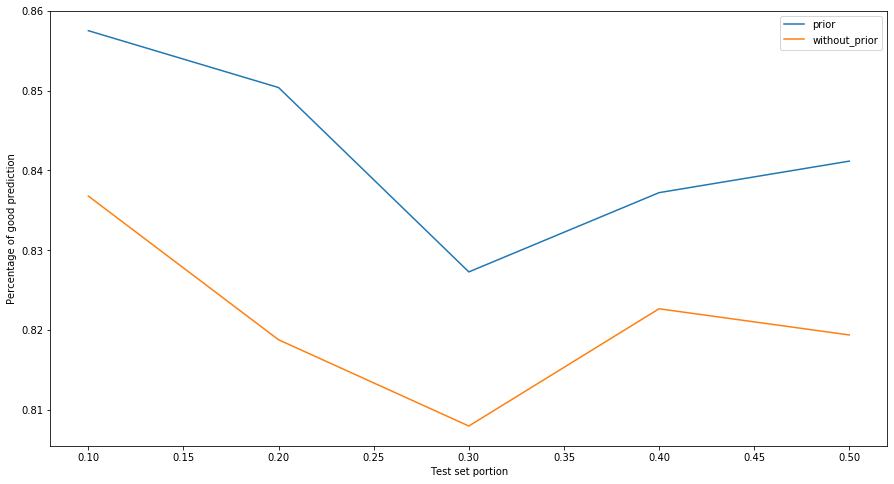

In [14]:
test_size = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(test_size))
prediction_without_prior = np.zeros(len(test_size))

for i in range(len(test_size)):
    Xapp_sat, Zapp_sat, Xtst_sat, Ztst_sat, mprior_sat, Sprior_sat = data_processing("dataset/satimage.csv")

    pi_sat, mu_sat, Sig_sat = QDA(Xapp_sat, Zapp_sat, mprior_sat, df_exp_sat, Sprior_sat, df_cov_sat)
    prob_sat, pred_sat = evaluation(Xtst_sat, pi_sat, mu_sat, Sig_sat)
    prediction[i] = precision_score(np.argmax(Ztst_sat, axis=1), pred_sat, average='weighted')

    pi_sat_2, mu_sat_2, Sig_sat_2 = QDA_without_prior(Xapp_sat, Zapp_sat)
    prob_sat_2, pred_sat_2 = evaluation(Xtst_sat, pi_sat_2, mu_sat_2, Sig_sat_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_sat, axis=1), pred_sat_2, average='weighted')

plt.figure(figsize=(15, 8))
plt.plot(test_size, prediction)
plt.plot(test_size, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

## Segment test

In [15]:
Xapp_seg, Zapp_seg, Xtst_seg, Ztst_seg, mprior_seg, Sprior_seg = data_processing("dataset/segment.csv",
                                                                                n_components_pca=17)

df_exp_seg = 0.5
df_cov_seg = Xapp_seg.shape[1] + 1

pi_seg, mu_seg, Sig_seg = QDA(Xapp_seg, Zapp_seg, mprior_seg, df_exp_seg, Sprior_seg, df_cov_seg)
prob_seg, pred_seg = evaluation(Xtst_seg, pi_seg, mu_seg, Sig_seg)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_seg, axis=1), pred_seg))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_seg, axis=1), pred_seg))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_seg, axis=1), pred_seg, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
-----------------------------------------------------------


Confusion matrix

 [[ 83   2   0   0   0   0   1]
 [  0 104   1   0   0   0   4]
 [  0   3  54   0   0   0  39]
 [  0   0   1 102   0   0   0]
 [  0   1   2   0  93   0   1]
 [  0   1   0   0   0  97   0]
 [  0  21   4   0   0   0  79]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.97      0.98        86
           1       0.79      0.95      0.86       109
           2       0.87      0.56      0.68        96
           3       1.00      0.99      1.00       103
           4       1.00      0.96      0.98        97
           5       1.00      0.99      0.99        98
           6       0.64      0.76      0.69       104

    accuracy                           0.88      

In [16]:
pi_seg_2, mu_seg_2, Sig_seg_2 = QDA_without_prior(Xapp_seg, Zapp_seg)
prob_seg_2, pred_seg_2 = evaluation(Xtst_seg, pi_seg_2, mu_seg_2, Sig_seg_2)


print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_seg, axis=1), pred_seg_2))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_seg, axis=1), pred_seg_2))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_seg, axis=1), pred_seg_2, average='weighted'))

-----------------------------------------------------------


Confusion matrix

 [[ 83   2   0   0   0   0   1]
 [  0 103   1   0   1   0   4]
 [  0   2  57   0   0   0  37]
 [  0   0   0 102   0   0   1]
 [  0   1   2   0  94   0   0]
 [  0   0   0   0   0  97   1]
 [  0  18   4   0   0   0  82]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.97      0.98        86
           1       0.82      0.94      0.88       109
           2       0.89      0.59      0.71        96
           3       1.00      0.99      1.00       103
           4       0.99      0.97      0.98        97
           5       1.00      0.99      0.99        98
           6       0.65      0.79      0.71       104

    accuracy                           0.89       693
   macro avg       0.91      0.89      0.89       693
weighted avg       0.90      0.89      0.89       693

------------------

Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}


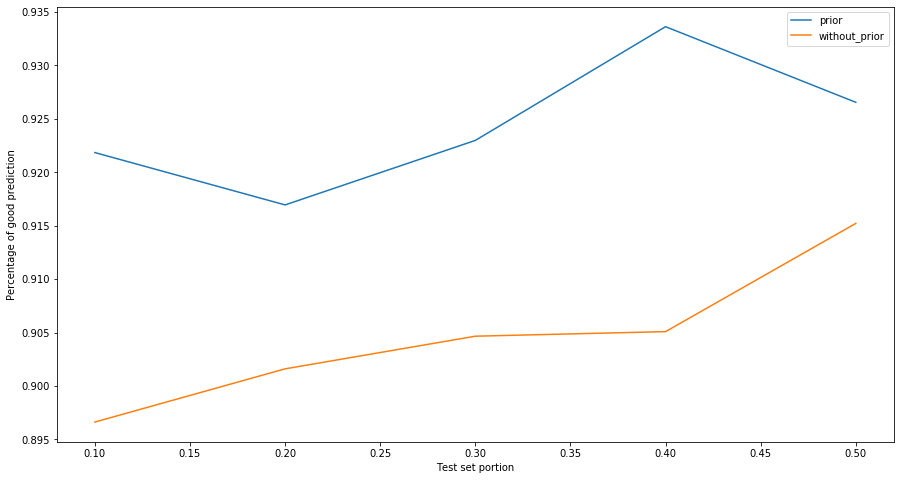

In [17]:
test_size = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(test_size))
prediction_without_prior = np.zeros(len(test_size))

for i in range(len(test_size)):
    Xapp_seg, Zapp_seg, Xtst_seg, Ztst_seg, mprior_seg, Sprior_seg = data_processing("dataset/segment.csv",
                                                                                n_components_pca=10)

    pi_seg, mu_seg, Sig_seg = QDA(Xapp_seg, Zapp_seg, mprior_seg, df_exp_seg, Sprior_seg, df_cov_seg)
    prob_seg, pred_seg = evaluation(Xtst_seg, pi_seg, mu_seg, Sig_seg)
    prediction[i] = precision_score(np.argmax(Ztst_seg, axis=1), pred_seg, average='weighted')

    pi_seg_2, mu_seg_2, Sig_seg_2 = QDA_without_prior(Xapp_seg, Zapp_seg)
    prob_seg_2, pred_seg_2 = evaluation(Xtst_seg, pi_seg_2, mu_seg_2, Sig_seg_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_seg, axis=1), pred_seg_2, average='weighted')

plt.figure(figsize=(15, 8))
plt.plot(test_size, prediction)
plt.plot(test_size, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()